# Análise de Índices Espectrais para Estudo da Ilha de Calor em Castanhal - PA

Código utilizado para artigo do SBSR 2025

Etapas:
* Obtenção de Imagem Mediana de 2023 do Landsat-8 na área de interesse pelo Google Earth Engine
* Calculo da Temperatura de Superfície (LST), Índice Melhorado de Vegetação (EVI) e Índice de Urbanização (UI)
* Obtenção da Classificação de Uso e Cobertura do Solo por MapBiomas
* Transformação da Imagem para Dataframe e Amostragem de pontos em quatro classes de solo
* Geração dos Mapas de Índices Espectrais
* Análise da Relação Estatística da LST com os Índices EVI e UI

In [ ]:
!pip install rasterio cartopy matplotlib_scalebar

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 50.3 MB/s eta 0:00:00


In [ ]:
import sys
import time
import json
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

import rasterio
from rasterio.plot import show
from pyproj import CRS, transform

In [30]:
# Para execução no Google Colab
from google.colab import drive
drive.mount('/content/drive')

dir  = '/content/drive/MyDrive/Artigos/RS_UHI_Amazon'
dir_img = f'{dir}/Images'

metadata_file_path = f'{dir_img}/mtl_2023.json'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Para execução em Jupyter Notebook local
#import os
#dir = os.getcwd()
#dir_img = f'{dir}/Imagens'
#metadata_file_path = os.path.join(dir_img, 'mtl_2023.json')

In [ ]:
# Coordenadas delimitando a região de interesse
cast_shp = [[-48.0185, -1.3733], [-48.0185, -1.2243], [-47.8405, -1.2243], [-47.8405, -1.3733]]

# Obtenção de Imagem Mediana de 2023 do Landsat-8 na área de interesse pelo Google Earth Engine

In [ ]:
import ee
import geemap.core as geemap

In [ ]:
ee.Authenticate()

True

In [ ]:
ee.Initialize(project='geers-phvguimaraesdev')

In [ ]:
roi = ee.Geometry.Polygon(cast_shp)

In [ ]:
def maskL8sr(image):

    # Mascarar pixels de Nuvem e Sombra de Nuvem a partir dos bits de QA

    qa = image.select('QA_PIXEL')
    cloudsBitMask = (1 << 3)  #  bit 3 - Nuvem
    cloudShadowBitMask = (1 << 4) #  bit 4 - Sombra de Nuvem

    cloud_shadow_clear = qa.bitwiseAnd(cloudShadowBitMask).eq(0)
    clouds_clear = qa.bitwiseAnd(cloudsBitMask).eq(0)
    mask = cloud_shadow_clear.And(clouds_clear)

    return image.updateMask(mask)

In [ ]:
def export_to_drive(image, description, folder='Images', scale=30, ROI=None, max_pixels=1e9):

    # Exportar imagem obtida para a pasta selecionada no Google Drive

    if region is None:
        raise ValueError("ROI must be provided as a ee.Geometry")

    region = ROI.getInfo()['coordinates']

    task = ee.batch.Export.image.toDrive(**{
        'image': image,
        'description': description,
        'folder': folder,
        'scale': scale,
        'region': region,
        'maxPixels': max_pixels
    })

    task.start()

    print(f'Starting export task: {description}')

    while task.active():
        print('Task is running...')
        time.sleep(10)

    status = task.status()

    if status['state'] == 'COMPLETED':
        print(f'Task {description} completed successfully.')
    else:
        print(f'Task {description} failed with status: {status["state"]}')
        print(f'Reason: {status.get("error_message", "Unknown error")}')

    return status['state']

In [ ]:
# Obter a lista de imagens de 2023 na região de interesse
col_2023 = ee.ImageCollection('LANDSAT/LC08/C02/T1') \
    .filterDate('2023-01-01', '2023-12-30') \
    .filterBounds(roi) \
    .map(maskL8sr)

In [ ]:
# Extract Digital Number Image Median
image_2023 = col_2023.median()

In [ ]:
# Retrieve metadata using getInfo()
mtl_2023 = col_2023.first().getInfo()
# Print metadata to see the structure
print(mtl_2023)

In [ ]:
# save metadata in JSON file
with open(metadata_file_path, 'w') as file:
    json.dump(mtl_2023, file, indent=4)

In [ ]:
# Export Image to drive
export_to_drive(image_2023, 'dn_img_2023', ROI=roi)

Starting export task: dn_img_2023
Task is running...
Task is running...
Task is running...
Task is running...
Task is running...
Task dn_img_2023 completed successfully.


'COMPLETED'

# Calculo da Temperatura de Superfície (LST), Índice Melhorado de Vegetação (EVI) e Índice de Urbanização (UI) + Recorte do Uso e Cobertura do Solo MapBiomas

In [ ]:
# Imagem e metadados obtidos

img_2023_path = f'{dir_img}/dn_img_2023.tif'

with open(metadata_file_path, 'r') as file:
    mtl_2023 = json.load(file)

In [ ]:
def spectral_indices_calculation(src, metadata):

  # Geração dos Índices Espectrais a partir da imagem em Números Digitais (DN)

  toa_bands = {}

  ## Conversão de DN para Refletância de Topo de Atmosfera - Bandas Opticas

  for i in range(1, 8):
        band_name = f'B{i}'
        band_data = src.read(i)
        mult = float(metadata['properties'][f'REFLECTANCE_MULT_BAND_{i}'])
        add = float(metadata['properties'][f'REFLECTANCE_ADD_BAND_{i}'])
        toa_bands[band_name] = band_data * mult + add

  ## Conversão de DN para Radiância Espectral TOA - Banda Termal

  band_name = 'B10'
  band_data = src.read(10)
  mult = float(metadata['properties']['RADIANCE_MULT_BAND_10'])
  add = float(metadata['properties']['RADIANCE_ADD_BAND_10'])
  L = band_data * mult + add

  ## Radiância para Temperatura de Brilho

  k1 = float(metadata['properties']['K1_CONSTANT_BAND_10'])
  k2 = float(metadata['properties']['K2_CONSTANT_BAND_10'])
  bt = k2 / np.log((k1/L)+1)

  ## NDVI para cálculo da Proporção de Vegetação e Emissividade do Solo

  nir = toa_bands['B5']
  red = toa_bands['B4']

  ndvi = (nir-red) / (nir+red)
  toa_bands['NDVI'] = ndvi
  pv = pow(((ndvi - ndvi.min()) / (ndvi.max() - ndvi.min())), 2)
  em = pv*0.004 + 0.986

  ## Temperatura de Brilho para Temperatura de Superfície (LST)

  w = 11.5e-6 # Comprimento médio da Onda Termal
  p = 1.438e-2 # Constante
  toa_bands['LST'] = (bt / (1 + w * bt * np.log(em) / p)) - 273.15

  ## Índices Espectrais EVI e UI

  blue = toa_bands['B2']
  swir2 = toa_bands['B7']

  toa_bands['EVI'] = 2.5*(nir - red) / (nir + 6*red - 7.5*blue + 1)
  toa_bands['UI'] = (swir2 - nir) / (swir2 + nir)

  return toa_bands

In [ ]:
src = rasterio.open(img_2023_path)

crs = src.crs
affine = src.transform
bounds = src.bounds
res = src.res

bands_2023 = spectral_indices_calculation(src, mtl_2023)

In [ ]:
# Classificação Uso e Cobertura da Terra MapBiomas - Castanhal/PA

# Obtido em: https://github.com/mapbiomas-brazil/user-toolkit
cast_lulc_path = f'{dir_img}/mapbiomas-brazil-collection-90-castanhal-2023.tif'

# Obter limite da Área de Interesse
roi_raster = rasterio.open(img_2023_path)
roi_bounds = roi_raster.bounds

# Cortar imagem
cast_lulc = rasterio.open(cast_lulc_path)
roi_window = cast_lulc.window(*roi_bounds)
cast_lulc_img = cast_lulc.read(1, window=roi_window)


# Adicionar às bandas
bands_2023['LULC'] = cast_lulc_img

# Geração dos Mapas de Índices Espectrais

In [ ]:
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patheffects as path_effects
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.transforms import Affine2D
import matplotlib.colors as mcolors

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib_scalebar.scalebar import ScaleBar

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from shapely.geometry import Polygon
from geopy.distance import geodesic

#
def decimal_to_deg_min(value, is_latitude):
    # Get absolute degrees
    degrees = int(abs(value))
    # Calculate minutes
    minutes = int((abs(value) - degrees) * 60)

    # Determine direction (W/E for longitude, N/S for latitude)
    if is_latitude:
        direction = 'N' if value >= 0 else 'S'
    else:
        direction = 'E' if value >= 0 else 'W'

    return f"{degrees}° {minutes}' {direction}"

# Formatter function for longitude
def format_longitude(x, pos):
    return decimal_to_deg_min(x, is_latitude=False)

# Formatter function for latitude
def format_latitude(y, pos):
    return decimal_to_deg_min(y, is_latitude=True)

# Formatter function for latitude and lomgitude in cartopy
def decimal_to_deg_min_cpy(value, is_latitude):
    degrees = int(abs(value))
    minutes = int((abs(value) - degrees) * 60)

    if is_latitude:
      direction = 'N' if value >= 0 else 'S'
    else:
      direction = 'E' if value >= 0 else 'W'

    return f"{degrees}°{minutes}' {direction}"

#left = -48.018545197324904
#right = -47.840409276484
#top = -1.22404440614126
#bottom = -1.3733444063619245
extent = [bounds.left, bounds.right, bounds.top, bounds.bottom]

# Obtain the points of reference
center_latitude = (bounds.bottom + bounds.top) / 2
point1 = (center_latitude, bounds.left)
point2 = (center_latitude, bounds.left + 1)

# Calculate the distance in meters between these two points
distance_meters = geodesic(point1, point2).meters

Mapa de calor

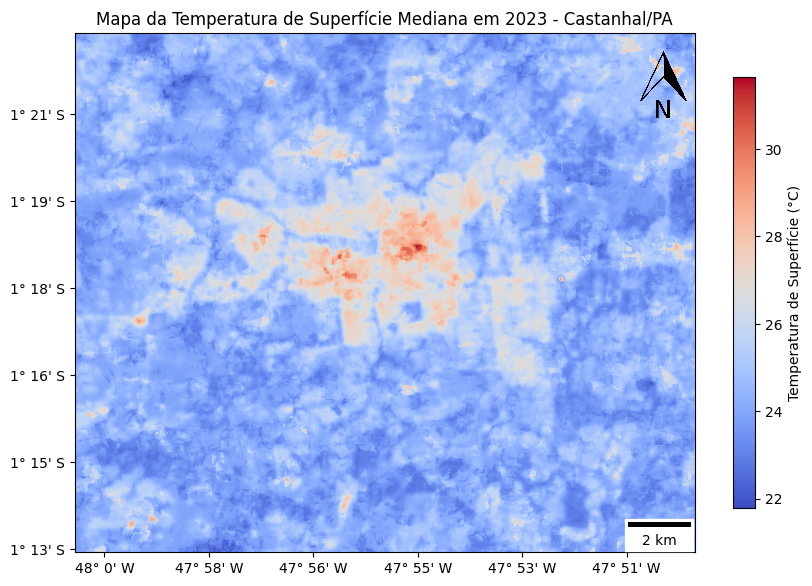

In [31]:
plt.figure(figsize=(10, 8))
img = plt.imshow(bands_2023['LST'], cmap='coolwarm', extent=extent, origin='upper')
plt.colorbar(img, label='Temperatura de Superfície (°C)', shrink=0.7)
#plt.xlabel("Longitude")
#plt.ylabel("Latitude")

plt.gca().xaxis.set_major_formatter(FuncFormatter(format_longitude))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_latitude))

plt.gca().xaxis.set_major_locator(MaxNLocator(6))
plt.gca().yaxis.set_major_locator(MaxNLocator(6))

# Add a scale bar using the calculated distance for one degree of longitude
scalebar = ScaleBar(distance_meters, units="m", dimension="si-length", location='lower right')
plt.gca().add_artist(scalebar)

# Seta Norte
img = plt.imread(f"{dir_img}/north_arrow.png")
imagebox = OffsetImage(img, zoom=0.020)
ab = AnnotationBbox(imagebox, (0.95, 0.90), frameon=False, xycoords='axes fraction')
plt.gca().add_artist(ab)

# Display the plot
plt.title("Mapa da Temperatura de Superfície Mediana em 2023 - Castanhal/PA")
plt.savefig(f'{dir_img}/LST_Map_Median_2023_Cast-PA.jpeg', bbox_inches='tight', format='jpeg', dpi=300)
plt.show()

Mapa de classes do solo

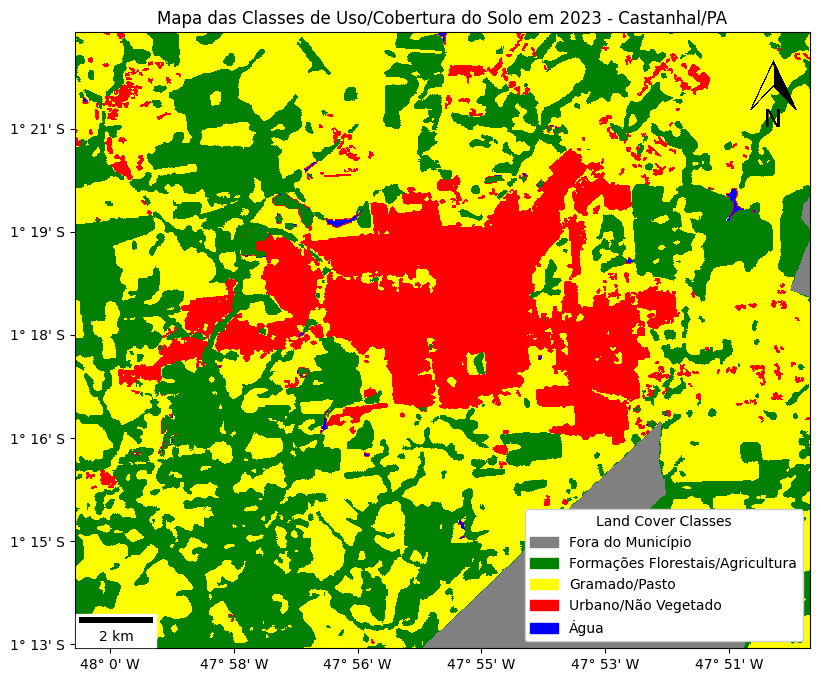

In [32]:
# Define class values and corresponding colors
#classes = [0, 3, 6, 9, 11, 12, 15, 24, 25, 30, 33, 35, 39, 41]
colors = ['grey', 'green', 'yellow', 'red', 'blue', 'green']
class_labels = ['Fora do Município', 'Formações Florestais/Agricultura', 'Gramado/Pasto', 'Urbano/Não Vegetado', 'Água']

#['Forest Formation', 'Áreas Naturales Inundables ', 'Forest Plantation',
#                'Agriculture', 'Wetland', 'Grassland', 'Pasture',
#                'Urban Infrastructure', 'Other Non Vegetated Area', 'Mining',
#                'River, Lake and Ocean', 'Oil Palm', 'Soy Beans', 'Mosaic of Crops']

# Create custom colormap
cmap = mcolors.ListedColormap(colors)
bounds = [0, 2.5, 11.5, 15.5, 30.5, 33.5, 41]  # Set boundaries between classes
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(10, 8))
img = plt.imshow(bands_2023['LULC'], cmap=cmap, norm=norm, extent=extent, origin='upper')

# Add a custom legend
legend_patches = [
    mpatches.Patch(color=colors[i], label=class_labels[i]) for i in range(len(class_labels))
]
plt.legend(handles=legend_patches, loc='lower right',
           title="Land Cover Classes", framealpha=1)

plt.gca().xaxis.set_major_formatter(FuncFormatter(format_longitude))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_latitude))

plt.gca().xaxis.set_major_locator(MaxNLocator(6))
plt.gca().yaxis.set_major_locator(MaxNLocator(6))

# Add a scale bar using the calculated distance for one degree of longitude
scalebar = ScaleBar(distance_meters, units="m", dimension="si-length", location='lower left')
plt.gca().add_artist(scalebar)

# Seta Norte
img = plt.imread(f"{dir_img}/north_arrow.png")
imagebox = OffsetImage(img, zoom=0.020)
ab = AnnotationBbox(imagebox, (0.95, 0.90), frameon=False, xycoords='axes fraction')
plt.gca().add_artist(ab)

# Display the plot
plt.title("Mapa das Classes de Uso/Cobertura do Solo em 2023 - Castanhal/PA")
plt.savefig(f'{dir_img}/LULC_Map_2023_Cast-PA.jpeg', bbox_inches='tight', format='jpeg', dpi=300)
plt.show()

Mapa da Cidade

In [ ]:
# Carregar o shapefile dos municípios brasileiros
shapefile_path = f'{dir}/shp_para/limites_municipais_ibge.shp'
brazil_municipalities = gpd.read_file(shapefile_path)

# Filtrar para o município de Castanhal no estado do Pará
para = brazil_municipalities[brazil_municipalities['siglauf'] == 'PA']
castanhal = para[para['nmmun'].str.upper() == 'CASTANHAL']
cast_point = castanhal.to_crs('+proj=cea').centroid.to_crs(castanhal.crs)
#castanhal = brazil_municipalities[(brazil_municipalities['siglauf'] == 'PA') &
#                                  (brazil_municipalities['nmmun'].str.upper() == 'CASTANHAL')]

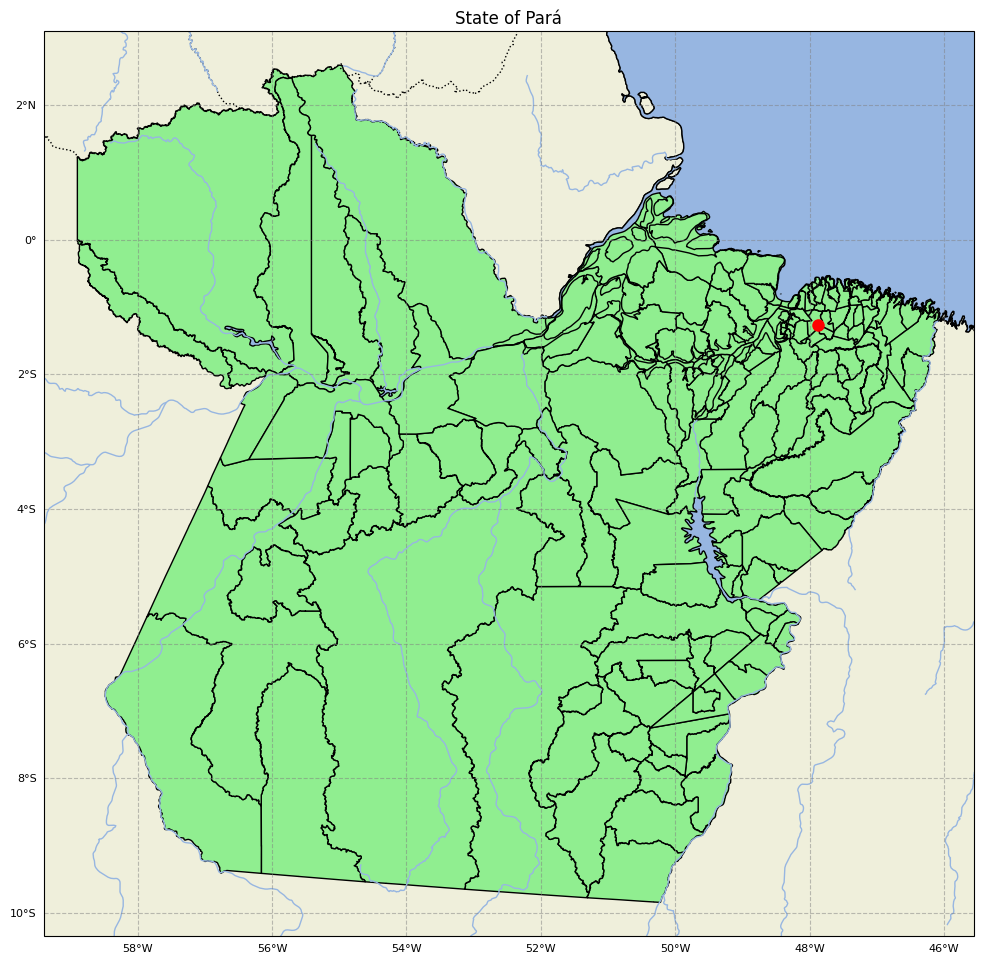

In [ ]:
# Criar a figura e os eixos principais com tamanho ajustado
fig, ax_main = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# Plotar o mapa do estado do Pará
para.plot(ax=ax_main, color='lightgreen', edgecolor='black', transform=ccrs.PlateCarree())

# Adicionar os pontos específicos ao mapa principal
ax_main.plot(cast_point.x, cast_point.y, marker='o', color='red', markersize=8, transform=ccrs.PlateCarree())

# Definir o título do mapa principal
ax_main.set_title('State of Pará')

# Ajustar o limite do mapa para focar mais detalhadamente no estado do Pará
# Ajuste os limites para maior zoom
buffer = 0.5  # Ajuste o valor do buffer conforme necessário para obter o nível de zoom desejado
xmin, ymin, xmax, ymax = para.total_bounds
ax_main.set_extent([xmin - buffer, xmax + buffer, ymin - buffer, ymax + buffer], crs=ccrs.PlateCarree())

ax_main.add_feature(cfeature.BORDERS, linestyle=':')
ax_main.add_feature(cfeature.COASTLINE)
ax_main.add_feature(cfeature.LAND, edgecolor='black')
ax_main.add_feature(cfeature.OCEAN)
ax_main.add_feature(cfeature.LAKES, edgecolor='black')
ax_main.add_feature(cfeature.RIVERS)

g2 = ax_main.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', alpha=0.5, linestyle='--')
g2.top_labels = False  # Turn off top labels if preferred
g2.right_labels = False  # Turn off right labels if preferred

# Customize the format to display degrees and minutes if needed
g2.xlabel_style = {'size': 8, 'color': 'black'}
g2.ylabel_style = {'size': 8, 'color': 'black'}

plt.show()


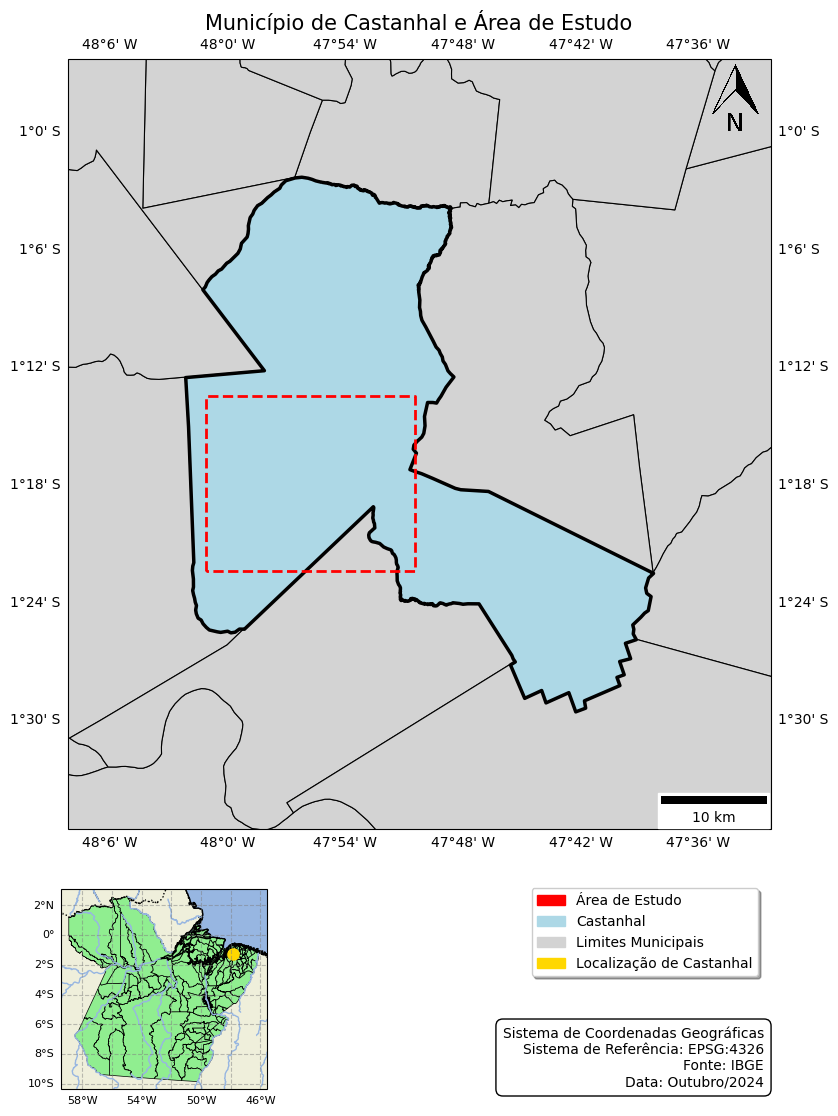

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})

para.plot(ax=ax, edgecolor='black', facecolor='lightgrey', linewidth=0.8, transform=ccrs.PlateCarree())
castanhal.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=2.5, transform=ccrs.PlateCarree())
ax.set_title('Município de Castanhal e Área de Estudo', fontsize=15)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)


cast = [[-48.0185, -1.3733], [-48.0185, -1.2243], [-47.8405, -1.2243], [-47.8405, -1.3733]]
roi_gdf = gpd.GeoDataFrame(index=[0],crs='EPSG:4326',geometry=[Polygon(cast_shp)])
# Plotar o ROI urbano (ajuste as cores e estilo conforme necessário)
roi_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, linestyle='--', transform=ccrs.PlateCarree())


# Ajustar limites do gráfico para focar no município
xmin, ymin, xmax, ymax = castanhal.total_bounds
ax_buffer = 0.1  # Ajuste o valor do buffer para um melhor enquadramento do município
ax.set_extent(
    [xmin - ax_buffer, xmax + ax_buffer, ymin - ax_buffer, ymax + ax_buffer],
    crs=ccrs.PlateCarree())

# Set up gridlines and custom format for labels
gl = ax.gridlines(draw_labels=True, alpha=0, linestyle='--')
gl.xformatter = FuncFormatter(lambda x, pos: decimal_to_deg_min_cpy(x, is_latitude=False))
gl.yformatter = FuncFormatter(lambda y, pos: decimal_to_deg_min_cpy(y, is_latitude=True))
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# Add a scalebar
scalebar = ScaleBar(distance_meters, units="m", dimension="si-length", location='lower right')
ax.add_artist(scalebar)

# Seta Norte
img = plt.imread(f"{dir_img}/north_arrow.png")
imagebox = OffsetImage(img, zoom=0.020)
ab = AnnotationBbox(imagebox, (0.95, 0.95), frameon=False, xycoords='axes fraction')
plt.gca().add_artist(ab)

# Custom legend in the bottom center
legend_handles = [
    mpatches.Patch(color='red', label='Área de Estudo'),
    mpatches.Patch(color='lightblue', label='Castanhal'),
    mpatches.Patch(color='lightgrey', label='Limites Municipais'),
    mpatches.Patch(color='gold', label='Localização de Castanhal')

]
# Modify the legend to stack vertically
plt.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(0.65, -0.2),
           fancybox=True, shadow=True, ncol=1)


text_str = "Sistema de Coordenadas Geográficas\nSistema de Referência: EPSG:4326\nFonte: IBGE\nData: Outubro/2024"
plt.text(0.80, -0.15, text_str, transform=fig.transFigure, fontsize=10,
         verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


# Mini Mapa do Pará

inset_ax = fig.add_axes([0.2, -0.15, 0.2, 0.2], projection=ccrs.PlateCarree())
para.plot(ax=inset_ax, edgecolor='black', facecolor='lightgreen', linewidth=0.5, transform=ccrs.PlateCarree())

#castanhal.plot(ax=inset_ax, color='gold', edgecolor='black', linewidth=1, transform=ccrs.PlateCarree())
inset_ax.plot(cast_point.x, cast_point.y, marker='o', color='gold', markersize=8, transform=ccrs.PlateCarree())

#inset_ax.set_extent([-74, -34, -34, 5], crs=ccrs.PlateCarree())
buffer = 0.5  # Ajuste o valor do buffer conforme necessário para obter o nível de zoom desejado
xmin, ymin, xmax, ymax = para.total_bounds
inset_ax.set_extent([xmin - buffer, xmax + buffer, ymin - buffer, ymax + buffer], crs=ccrs.PlateCarree())

inset_ax.add_feature(cfeature.BORDERS, linestyle=':')
inset_ax.add_feature(cfeature.COASTLINE)
inset_ax.add_feature(cfeature.LAND, edgecolor='black')
inset_ax.add_feature(cfeature.OCEAN)
inset_ax.add_feature(cfeature.LAKES, edgecolor='black')
inset_ax.add_feature(cfeature.RIVERS)

# Coordenadas
gl_inset = inset_ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', alpha=0.5, linestyle='--')
gl_inset.top_labels = False  # Turn off top labels if preferred
gl_inset.right_labels = False  # Turn off right labels if preferred

# Customize the format to display degrees and minutes if needed
gl_inset.xlabel_style = {'size': 8, 'color': 'black'}
gl_inset.ylabel_style = {'size': 8, 'color': 'black'}

plt.savefig(f'{dir_img}/Castanhal_Mapa.jpeg', bbox_inches='tight', format='jpeg', dpi=300)
plt.show()

# Transformação da Imagem para Dataframe e Armazenamento da Tabela de Dados

In [ ]:
def array_to_dataframe(dataset, affine, band=''):

    data = dataset[band]

    # Get coordinates (meshgrid of rows and columns)
    cols, rows = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))

    # Convert rows and columns to x, y coordinates using the affine transform
    xs, ys = rasterio.transform.xy(affine, rows, cols)

    # Flatten the arrays for creating the DataFrame
    df = pd.DataFrame({
        'x': np.array(xs).flatten(),
        'y': np.array(ys).flatten(),
        band: data.flatten()
    })

    # Remove NoData values (assuming NoData is represented by NaNs or specific values)
    df = df[~np.isnan(df[band])]

    return df

In [ ]:
lst_df = array_to_dataframe(bands_2023, affine, 'LST')
ndvi_df = array_to_dataframe(bands_2023, affine, 'NDVI')
evi_df = array_to_dataframe(bands_2023, affine, 'EVI')
ui_df = array_to_dataframe(bands_2023, affine, 'UI')
lulc_df = array_to_dataframe(bands_2023, affine, 'LULC')

In [ ]:
merged_df = pd.merge(ndvi_df, lst_df, on=['x', 'y'], how='inner')
merged_df = pd.merge(merged_df, evi_df, on=['x', 'y'], how='inner')
merged_df = pd.merge(merged_df, ui_df, on=['x', 'y'], how='inner')
merged_df = pd.merge(merged_df, lulc_df, on=['x', 'y'], how='inner')

In [ ]:
print('LST min: ', merged_df['LST'].min())
print('LST max: ', merged_df['LST'].max())

LST min:  21.787463505732717
LST max:  31.648178015871167


In [ ]:
merged_df.set_index('LST', inplace=True)

In [ ]:
merged_df.to_csv(f'{dir_img}/df_2023.csv')

# Amostragem de Pontos por Classes de Solo

In [ ]:
merged_df = pd.read_csv(f'{dir_img}/df_2023.csv')

In [ ]:
cast_lulc_data = pd.read_csv(f'{dir_img}/mapbiomas-brazil-collection-90-castanhal-area.csv')

lulc_data = pd.DataFrame({
    'LULC': cast_lulc_data['class'],
    'LULC_Name': cast_lulc_data['class_name']
})

lulc_data

,LULC,LULC_Name
0,3,Forest Formation
1,6,Áreas Naturales Inundables - Leñosas (Bosque I...
2,9,Forest Plantation
3,11,Wetland
4,12,"Grassland (Pastizal, Formación Herbácea)"
5,15,Pasture
6,24,Urban Infrastructure
7,25,Other Non Vegetated Area
8,30,Mining
9,33,"River, Lake and Ocean"


In [ ]:
merged_df = pd.merge(merged_df, lulc_data, on='LULC', how='left')

In [ ]:
merged_df.drop(['x', 'y','LULC'], axis=1, inplace=True)

In [ ]:
print(merged_df['LULC_Name'].value_counts())

LULC_Name
Pasture                                                    175123
Forest Formation                                           103182
Urban Infrastructure                                        47305
Áreas Naturales Inundables - Leñosas (Bosque Inundable)      6392
Other Non Vegetated Area                                     4218
Mosaic of Crops                                              1259
River, Lake and Ocean                                         527
Mining                                                        218
Grassland (Pastizal, Formación Herbácea)                      166
Oil Palm                                                      153
Soy Beans                                                      68
Wetland                                                         3
Name: count, dtype: int64


In [ ]:
# Define a dictionary mapping old class names to new ones
name_map = {
    'Pasture': 'pasture',
    'Forest Formation': 'forest',
    'Urban Infrastructure': 'urban'
}

# Replace class names based on the mapping
merged_df['LULC_Name'] = merged_df['LULC_Name'].replace(name_map)

classes = ['pasture', 'forest', 'urban']
filter_df = merged_df[merged_df['LULC_Name'].isin(classes)]

print(filter_df['LULC_Name'].value_counts())

LULC_Name
pasture    175123
forest     103182
urban       47305
Name: count, dtype: int64


In [ ]:
# Define a dictionary mapping old class names to new ones
name_map = {
    'Pasture': 'pastagem',
    'Forest Formation': 'floresta',
    'Urban Infrastructure': 'urbano'
}

# Replace class names based on the mapping
merged_df['LULC_Name'] = merged_df['LULC_Name'].replace(name_map)

classes = ['pastagem', 'floresta', 'urbano']
filter_df = merged_df[merged_df['LULC_Name'].isin(classes)]


In [ ]:
# Set the number of samples you want per bin
samples_per_bin = 300
# Stratified sampling
df_sampled_lulc = filter_df.groupby('LULC_Name').apply(lambda x: x.sample(n=samples_per_bin, random_state=42))
# Reset the index after sampling
df_sampled_lulc = df_sampled_lulc.reset_index(drop=True)
# Check the result
print(df_sampled_lulc['LULC_Name'].value_counts())

LULC_Name
floresta    300
pastagem    300
urbano      300
Name: count, dtype: int64


In [ ]:
summary_df = df_sampled_lulc.groupby('LULC_Name').agg({
    'LST': ['min', 'max', 'mean', 'std'],
    'EVI': ['min', 'max', 'mean', 'std'],
    'UI': ['min', 'max', 'mean', 'std']
}).reset_index()

In [ ]:
summary_df.round(2)

LULC_Name    LST                       EVI                      UI        \
               min    max   mean   std   min   max  mean   std   min   max   
0  floresta  22.19  25.46  23.82  0.47  0.45  0.85  0.72  0.06 -0.80 -0.37   
1  pastagem  22.92  27.19  24.64  0.64  0.18  0.83  0.60  0.10 -0.78 -0.20   
2    urbano  24.20  29.73  26.43  0.89  0.06  0.80  0.34  0.12 -0.70  0.11   

               
   mean   std  
0 -0.74  0.04  
1 -0.58  0.11  
2 -0.23  0.16

In [ ]:
labels_lulc = df_sampled_lulc['LULC_Name']
features_lulc = df_sampled_lulc.drop(['LULC_Name'], axis=1)
features_lulc.columns

Index(['LST', 'NDVI', 'EVI', 'UI'], dtype='object')

# Análise da Relação Estatística da LST com os Índices EVI e UI

In [ ]:
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from numpy.polynomial.polynomial import Polynomial
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
pearson_corr, pearson_p = pearsonr(df_sampled_lulc['UI'], df_sampled_lulc['LST'])
print(f'Pearson Correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3e})')

x_ui = df_sampled_lulc['UI'].values.reshape(-1, 1)
y = df_sampled_lulc['LST']

model_ui = LinearRegression().fit(x_ui, y)
slope_ui = model_ui.coef_[0]
intercept_ui = model_ui.intercept_
equation_ui = f'{slope_ui:.2f}x + {intercept_ui:.2f}'

score_ui = model_ui.score(x_ui, y)
pred_lin_ui = model_ui.predict(x_ui)
rmse_ui = mean_squared_error(y, pred_lin_ui, squared=False)
mae_ui = mean_absolute_error(y, pred_lin_ui)

print(f'Fit R² Score: {score_ui}')

print(f'RMSE: {rmse_ui}')
print(f'MAE: {mae_ui}')

Pearson Correlation: 0.884 (p-value: 1.839e-298)
Fit R² Score: 0.7810824389632828
RMSE: 0.6026827471066736
MAE: 0.4676909058549238


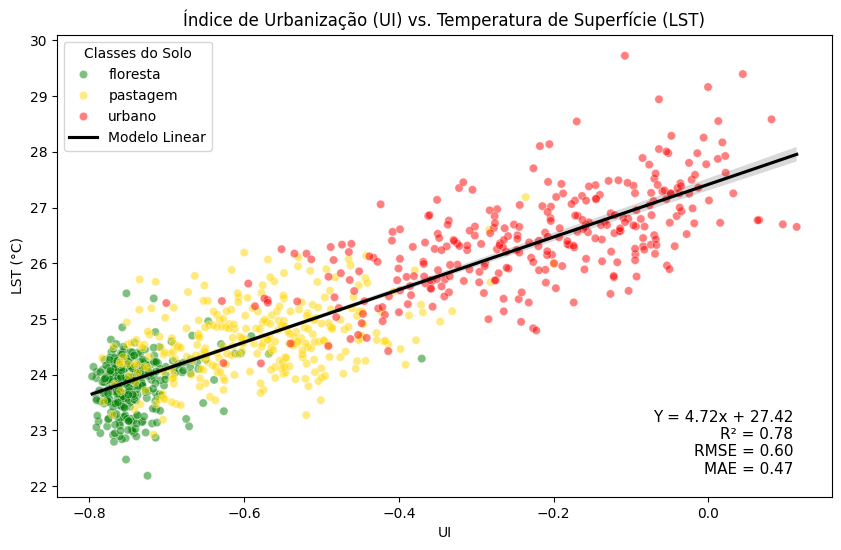

In [ ]:
lulc_colors = {
    'floresta': 'green', 'pastagem': 'gold', 'urbano': 'red', 'água': 'blue', 'exposto':'orange'
}

plt.figure(figsize=(10, 6))

sns.scatterplot(x='UI', y='LST', hue='LULC_Name', palette=lulc_colors, data=df_sampled_lulc, alpha=0.5)

sns.regplot(x='UI', y='LST', data=df_sampled_lulc, scatter=False, color='black', label='Modelo Linear')

plt.text(0.95, 0.05, f"Y = {equation_ui}\nR² = {score_ui:.2f}\nRMSE = {rmse_ui:.2f}\nMAE = {mae_ui:.2f}",
         transform=plt.gca().transAxes, fontsize=11, color='black',
         horizontalalignment='right')

plt.title('Índice de Urbanização (UI) vs. Temperatura de Superfície (LST)')
plt.xlabel('UI')
plt.ylabel('LST (°C)')
plt.legend(title='Classes do Solo')
plt.savefig(f'{dir_img}/UI_vs_LST_LULC.jpeg', bbox_inches='tight', format='jpeg', dpi=300)
plt.show()

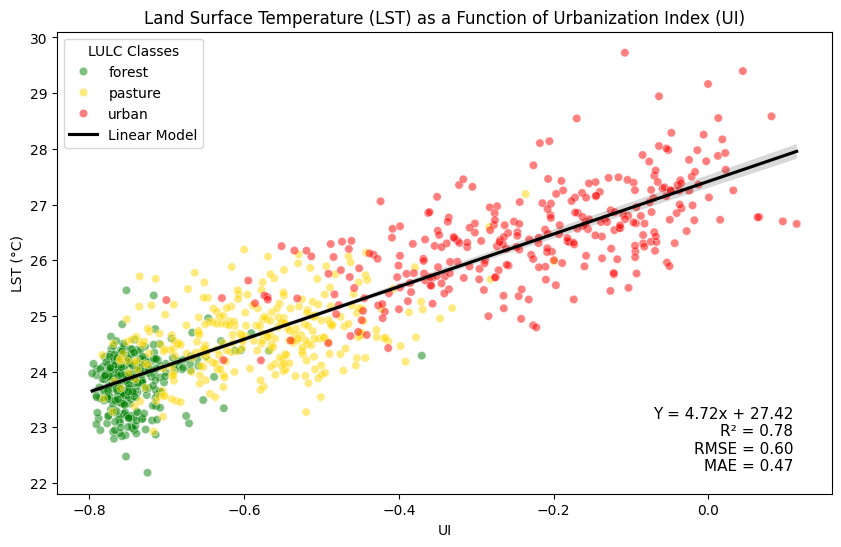

In [ ]:
lulc_colors = {
    'forest': 'green', 'pasture': 'gold', 'urban': 'red'
}

plt.figure(figsize=(10, 6))

sns.scatterplot(x='UI', y='LST', hue='LULC_Name', palette=lulc_colors, data=df_sampled_lulc, alpha=0.5)

sns.regplot(x='UI', y='LST', data=df_sampled_lulc, scatter=False, color='black', label='Linear Model')

plt.text(0.95, 0.05, f"Y = {equation_ui}\nR² = {score_ui:.2f}\nRMSE = {rmse_ui:.2f}\nMAE = {mae_ui:.2f}",
         transform=plt.gca().transAxes, fontsize=11, color='black',
         horizontalalignment='right')

plt.title('Land Surface Temperature (LST) as a Function of Urbanization Index (UI)')
plt.xlabel('UI')
plt.ylabel('LST (°C)')
plt.legend(title='LULC Classes')
plt.savefig(f'{dir_img}/UI_vs_LST_LULC_en.jpeg', bbox_inches='tight', format='jpeg', dpi=300)
plt.show()

In [ ]:
pearson_corr, pearson_p = pearsonr(df_sampled_lulc['EVI'], df_sampled_lulc['LST'])
print(f'Pearson Correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3e})')

x_evi = df_sampled_lulc['EVI'].values.reshape(-1,1)
y = df_sampled_lulc['LST']

model_evi = LinearRegression().fit(x_evi, y)
slope_evi = model_evi.coef_[0]
intercept_evi = model_evi.intercept_
equation_evi = f'{slope_evi:.2f}x + {intercept_evi:.2f}'

score_evi = model_evi.score(x_evi, y)
pred_lin_evi = model_evi.predict(x_evi)
rmse_evi = mean_squared_error(y, pred_lin_evi, squared=False)
mae_evi = mean_absolute_error(y, pred_lin_evi)

print(f'Fit R² Score: {score_evi}')

print(f'RMSE: {rmse_evi}')
print(f'MAE: {mae_evi}')

Pearson Correlation: -0.845 (p-value: 1.922e-246)
Fit R² Score: 0.7141797130707588
RMSE: 0.6886443427739016
MAE: 0.5328095151967355


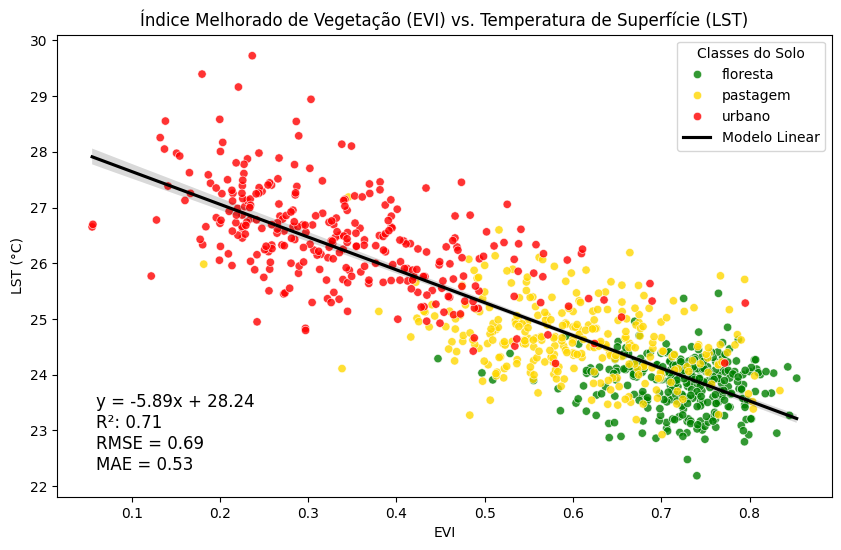

In [ ]:
lulc_colors = {
    'floresta': 'green', 'pastagem': 'gold', 'urbano': 'red', 'água': 'blue', 'exposto':'orange'
}

plt.figure(figsize=(10, 6))

sns.scatterplot(x='EVI', y='LST', hue='LULC_Name', palette=lulc_colors, data=df_sampled_lulc, alpha=0.8)

sns.regplot(x='EVI', y='LST', data=df_sampled_lulc, scatter=False, color='black', label='Modelo Linear')

plt.text(0.05, 0.05, f"y = {equation_evi}\nR²: {score_evi:.2f}\nRMSE = {rmse_evi:.2f}\nMAE = {mae_evi:.2f}",
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom')

plt.title('Índice Melhorado de Vegetação (EVI) vs. Temperatura de Superfície (LST)')
plt.xlabel('EVI')
plt.ylabel('LST (°C)')
plt.legend(title = 'Classes do Solo')
plt.savefig(f'{dir_img}/EVI_vs_LST_LULC.jpeg', bbox_inches='tight', format='jpeg', dpi=300)
plt.show()

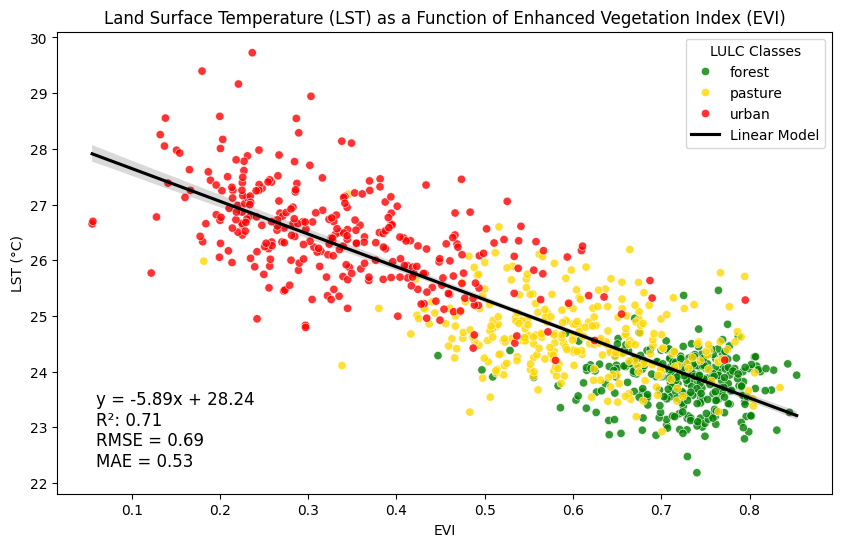

In [ ]:
lulc_colors = {
    'forest': 'green', 'pasture': 'gold', 'urban': 'red'
}
plt.figure(figsize=(10, 6))

sns.scatterplot(x='EVI', y='LST', hue='LULC_Name', palette=lulc_colors, data=df_sampled_lulc, alpha=0.8)

sns.regplot(x='EVI', y='LST', data=df_sampled_lulc, scatter=False, color='black', label='Linear Model')

plt.text(0.05, 0.05, f"y = {equation_evi}\nR²: {score_evi:.2f}\nRMSE = {rmse_evi:.2f}\nMAE = {mae_evi:.2f}",
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom')

plt.title('Land Surface Temperature (LST) as a Function of Enhanced Vegetation Index (EVI)')
plt.xlabel('EVI')
plt.ylabel('LST (°C)')
plt.legend(title = 'LULC Classes')
plt.savefig(f'{dir_img}/EVI_vs_LST_LULC_en.jpeg', bbox_inches='tight', format='jpeg', dpi=300)
plt.show()